In [74]:
!pip install -q tensorflow_io
import tensorflow_io as tfio
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as keras
import tensorflow_hub as hub

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from sklearn.metrics import confusion_matrix

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

     |████████████████████████████████| 24.1MB 124kB/s 
     |████████████████████████████████| 2.5MB 33.2MB/s 


In [2]:
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [ ]:
!nvidia-smi

### Connect to the TPU worker (DO NOT EXECUTE THE BELOW 3 CELLS IF YOU DO NOT NEED TPU PROCESSING)

The following code connects to the TPU worker and changes TensorFlow's default device to the CPU device on the TPU worker. It also defines a TPU distribution strategy that you will use to distribute model training onto the 8 separate TPU cores available on this one TPU worker. See TensorFlow's [TPU guide](https://www.tensorflow.org/guide/tpu) for more information.

In [ ]:
if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

KeyError: ignored

In [ ]:
# View some info of the TPU in this colaboratory
from tensorflow.python.profiler import profiler_client

tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

In [ ]:
#To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores). 
#At this size, the 128x128 hardware matrix multipliers of the TPU (see hardware section below) are most likely to be kept busy. 
#You start seeing interesting speedups from a batch size of 8 per core though. In the sample above, the batch size is scaled with the core count

# mixed precision
# On TPU, bfloat16/float32 mixed precision is automatically used in TPU computations.
# Enabling it in Keras also stores relevant variables in bfloat16 format (memory optimization).
# On GPU, specifically V100, mixed precision must be enabled for hardware TensorCores to be used.
# XLA compilation must be enabled for this to work. (On TPU, XLA compilation is the default)
MIXED_PRECISION = False
if MIXED_PRECISION:
    if tpu: 
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: #
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    print('8')
    
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    print('1')
    
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    print('else')

In [3]:
# Download folder and unzip it
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


182083584/182082353 [==============================] - 3s 0us/step


In [5]:
# Print commands
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

# Shuffle audio samples and print some info
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
print(type(filenames))
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Commands: ['no' 'up' 'go' 'right' 'yes' 'left' 'down' 'stop']
<class 'tensorflow.python.framework.ops.EagerTensor'>
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/33903159_nohash_1.wav', shape=(), dtype=string)


In [6]:
# Split dataset
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [7]:
'''
The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.
To load an audio file, you will use tf.audio.decode_wav, which returns the WAV-encoded audio as a Tensor and the sample rate.
A WAV file contains time series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time.
In a 16-bit system, like the files in mini_speech_commands, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. 
Note that tf.audio.decode_wav will normalize the values to the range [-1.0, 1.0].
'''
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


In [8]:
'''
You will now apply process_path to build your training set to extract the audio-label pairs and check the results. 
You'll build the validation and test sets using a similar procedure later on.
'''
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [9]:
print(type(files_ds))
print(files_ds)
print(type(waveform_ds))
print(waveform_ds.take(0))
audio, label = waveform_ds.take(2)
print(len(audio[0]))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<TensorSliceDataset shapes: (), types: tf.string>
<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<TakeDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>
12288


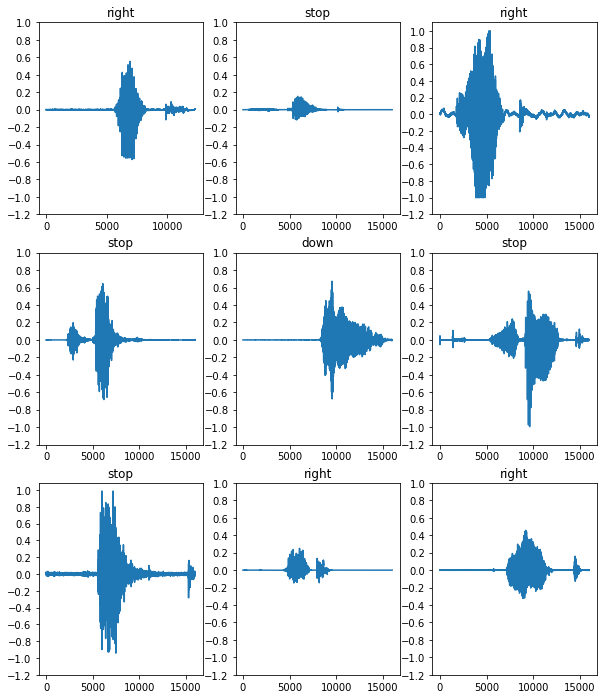

In [10]:
# Do some ploting to view the dataset
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [11]:
# We need the waveforms to have a similar length.
# This can be done by simply zero padding the audio clips that are shorter than one second.

def zero_pad_the_waveforms(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  return equal_length

In [12]:
# Explore the data
for waveform, label in waveform_ds.take(2000):
  label = label.numpy().decode('utf-8')
  audio_one = zero_pad_the_waveforms(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Audio one shape:', audio_one.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))
print(audio_one)

Label: up
Waveform shape: (16000,)
Audio one shape: (16000,)
Audio playback


tf.Tensor(
[ 0.00222778 -0.00701904  0.00305176 ... -0.00546265 -0.00537109
 -0.0045166 ], shape=(16000,), dtype=float32)


In [13]:
def get_zero_padded_waveforms_and_label_id(audio, label):
  audio_one = zero_pad_the_waveforms(audio)
  label_id = tf.argmax(label == commands)
  return audio_one, label_id

audio_zero_padded_ds = waveform_ds.map(get_zero_padded_waveforms_and_label_id, num_parallel_calls=AUTOTUNE)

In [14]:
# Helper function for dataset
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_zero_padded_waveforms_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = audio_zero_padded_ds
val_ds_gen = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

# Yamnet

In [15]:
# Download the model from TFHub
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [16]:
# Print the classes
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [17]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings, tf.repeat(label, num_embeddings))
  
  # extract embedding
train_ds = train_ds.map(extract_embedding).unbatch()
train_ds.element_spec

val_ds = val_ds_gen.map(extract_embedding).unbatch()
val_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [18]:
train_ds = train_ds.cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)

In [19]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(commands))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4104      
Total params: 528,904
Trainable params: 528,904
Non-trainable params: 0
_________________________________________________________________


In [20]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [21]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback,
                       verbose=1)

Epoch 1/20
200/200 [==============================] - 156s 712ms/step - loss: 1.8469 - accuracy: 0.3123 - val_loss: 1.6573 - val_accuracy: 0.3956
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 1.6028 - accuracy: 0.4095 - val_loss: 1.5645 - val_accuracy: 0.4269
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 1.4941 - accuracy: 0.4450 - val_loss: 1.5556 - val_accuracy: 0.4200
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 1.4245 - accuracy: 0.4764 - val_loss: 1.5656 - val_accuracy: 0.4125
Epoch 5/20
200/200 [==============================] - 1s 4ms/step - loss: 1.3651 - accuracy: 0.4915 - val_loss: 1.4954 - val_accuracy: 0.4519
Epoch 6/20
200/200 [==============================] - 1s 4ms/step - loss: 1.2980 - accuracy: 0.5253 - val_loss: 1.4865 - val_accuracy: 0.4550
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 1.2420 - accuracy: 0.5473 - val_loss: 1.4778 - val_accuracy: 0.4619
Ep

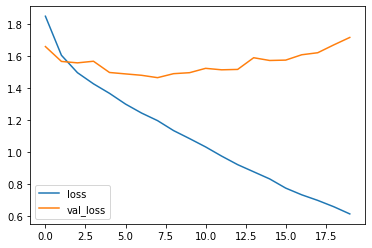

In [22]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [24]:
scores, embeddings, spectrogram = yamnet_model(get_waveform_and_label('/content/data/mini_speech_commands/stop/012c8314_nohash_0.wav')[0])
print(embeddings)
result = my_model(embeddings).numpy()

infered_class = commands[result.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

tf.Tensor(
[[0.         0.05924633 0.33343157 ... 0.         0.         0.        ]
 [0.06813311 0.0954982  0.26100913 ... 0.08122513 0.         0.        ]], shape=(2, 1024), dtype=float32)
The main sound is: stop


[2 0 6 ... 6 5 5]
[2 2 4 ... 3 5 5]
[[ 68  18  50  16  15  15  41  13]
 [  5  79  13   4   3  10   3  14]
 [ 25   9  41   4   9   5  25  15]
 [ 10   5   2 103  28  27  10  13]
 [  8   4   6   9 119   8   6  11]
 [  3  17  12  20  21  87  12   8]
 [ 63  16  33  28  15  14 129  22]
 [  6  22  23  14  20  26  12 108]]



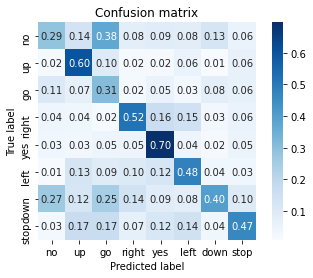

In [44]:
# Plot the confusion matrix

def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

# Get the result of the dataset
result = my_model.predict(val_ds)
result = np.argmax(result, axis=1)
print(result)

total = []
for element in val_ds.as_numpy_iterator(): 
  total.append(element[1])

all_total = np.concatenate(total)
print(all_total)

# Print the confusion matrix with sklearn
matrix = confusion_matrix(result, all_total)
print(matrix)
print()

# Print confusion matrix with Matplotlib and extra function
show_confusion_matrix(matrix, commands)

In [53]:
test_file = '/content/data/mini_speech_commands/stop/0132a06d_nohash_3.wav'

In [54]:
scores, embeddings, spectrogram = yamnet_model(zero_pad_the_waveforms(get_waveform_and_label(test_file)[0]))
print(embeddings)
result = my_model(embeddings).numpy()

infered_class = commands[result.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

tf.Tensor(
[[0.         0.30364364 0.         ... 0.         0.         0.        ]
 [0.         0.6178542  0.69099754 ... 0.         0.         0.        ]], shape=(2, 1024), dtype=float32)
The main sound is: stop


In [55]:
# Include reduce mean and expansion inside model
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    input = tf.math.reduce_mean(input, axis=self.axis)
    #input = tf.expand_dims(input, axis=self.axis)
    return input

In [56]:
saved_model_path = './speech_commands_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./speech_commands_yamnet/assets


INFO:tensorflow:Assets written to: ./speech_commands_yamnet/assets


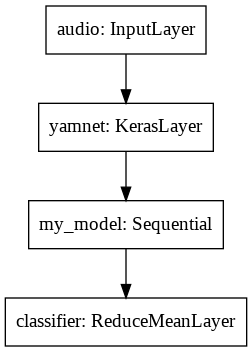

In [57]:
tf.keras.utils.plot_model(serving_model)

In [58]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [63]:
# Commands: ['no' 'up' 'go' 'right' 'yes' 'left' 'down' 'stop']
reloaded_results = reloaded_model(zero_pad_the_waveforms(get_waveform_and_label(test_file)[0]))
print(tf.squeeze(reloaded_results).numpy())
result = commands[tf.argmax(tf.squeeze(reloaded_results))]
#result = commands[tf.argmax(reloaded_results[0])]
print(f'The main sound is: {result}')

[-0.6849572  -2.979441   -0.9784702  -2.4188378   0.18893218 -2.2609248
 -2.2492838   2.131675  ]
The main sound is: stop


In [64]:
# Use with TF 2.5.0 no quantization
MODEL_PATH  = "./speech_commands_yamnet"
MODEL_SAVE_PATH = "/content/yamnet_speech_commands.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH)

tflite_model = converter.convert()
with tf.io.gfile.GFile(MODEL_SAVE_PATH, 'wb') as f:
  f.write(tflite_model)

In [65]:
# Use with TF 2.5.0 Dynamic range quantization
MODEL_PATH  = "./speech_commands_yamnet"
MODEL_SAVE_PATH_DRQ = "/content/yamnet_speech_commandsDRQ.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
with tf.io.gfile.GFile(MODEL_SAVE_PATH_DRQ, 'wb') as f:
  f.write(tflite_model)

In [70]:
input_wav = zero_pad_the_waveforms(get_waveform_and_label(test_file)[0])
input_shape_size = input_wav.shape[0]
print(input_shape_size)
interpreter = tf.lite.Interpreter(model_path=MODEL_SAVE_PATH)# or MODEL_SAVE_PATH_DRQ

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

input_data = np.array(input_wav, dtype=np.float32)
interpreter.resize_tensor_input(input_details[0]['index'], [input_shape_size], strict=True)

interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
result = commands[tf.argmax(output_data)]
print(f'The main sound is: {result}')

16000
[-0.6849501  -2.9794567  -0.9784995  -2.418827    0.18892634 -2.2609038
 -2.2492719   2.1316602 ]
The main sound is: stop


# Test recorded audio

In [71]:
@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    print(sample_rate)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [75]:
input = load_wav_16k_mono('left.wav')

Tensor("DecodeWav:1", shape=(), dtype=int32)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [76]:
print(type(input))
print(input)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.5115499e-05 1.3380266e-04
 1.4033940e-04], shape=(33280,), dtype=float32)


In [77]:
display.Audio(input, rate=16000)

In [79]:
test_result = reloaded_model(input)
print(test_result)
print(tf.squeeze(test_result).numpy())
result = commands[tf.argmax(tf.squeeze(test_result))]
# or
result = commands[tf.argmax(test_result)]
print(f'The main sound is: {result}')

tf.Tensor(
[-1.7317884 -2.4334898 -4.0389256 -2.585471   0.846524   1.7880734
 -2.2811852 -1.7908391], shape=(8,), dtype=float32)
[-1.7317884 -2.4334898 -4.0389256 -2.585471   0.846524   1.7880734
 -2.2811852 -1.7908391]
The main sound is: left


In [83]:
input_wav = input
input_shape_size = input_wav.shape[0]
print(input_shape_size)
interpreter = tf.lite.Interpreter(model_path=MODEL_SAVE_PATH)# or MODEL_SAVE_PATH_DRQ

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

input_data = np.array(input_wav, dtype=np.float32)
interpreter.resize_tensor_input(input_details[0]['index'], [input_shape_size], strict=True)

interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
result = commands[tf.argmax(output_data)]
print(f'The main sound is: {result}')

33280
[-1.7317914 -2.4334817 -4.03892   -2.5854757  0.8465174  1.7880689
 -2.2811842 -1.7908361]
The main sound is: left
